<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2021notebooks/2021_1108super_mario_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
import platform
isColab = True if platform.system().split('.')[0] == 'Linux' else False

if isColab:
    !pip install nes-py > /dev/null 2>&1
    !pip install gym-super-mario-bros > /dev/null 2>&1

# Playing Super Mario Bros with Deep Reinforcement Learning
- source: https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/

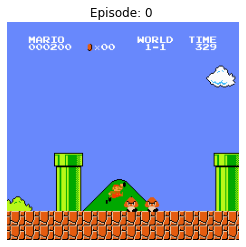

100%|██████████| 1/1 [00:38<00:00, 38.51s/it]


Episode 1 score = 673.0, average score = 673.0


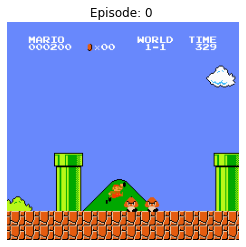

In [2]:
import torch
import torch.nn as nn
import random
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
import time
import pylab as pl
from IPython import display

class MaxAndSkipEnv(gym.Wrapper):
    """
        Each action of the agent is repeated over skip frames
        return only every `skip`-th frame
    """
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class MarioRescale84x84(gym.ObservationWrapper):
    """
    Downsamples/Rescales each frame to size 84x84 with greyscale
    """
    def __init__(self, env=None):
        super(MarioRescale84x84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return MarioRescale84x84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution." 
        # image normalization on RBG
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    """
    Each frame is converted to PyTorch tensors
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

    
class BufferWrapper(gym.ObservationWrapper):
    """
    Only every k-th frame is collected by the buffer
    """
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


class PixelNormalization(gym.ObservationWrapper):
    """
    Normalize pixel values in frame --> 0 to 1
    """
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


def create_mario_env(env):
    env = MaxAndSkipEnv(env)
    env = MarioRescale84x84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = PixelNormalization(env)
    return JoypadSpace(env, SIMPLE_MOVEMENT)
  
class DQNSolver(nn.Module):
    """
    Convolutional Neural Net with 3 conv layers and two linear layers
    """
    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)


class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dqn, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dqn = double_dqn
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Double DQN network
        if self.double_dqn:  
            self.local_net = DQNSolver(state_space, action_space).to(self.device)
            self.target_net = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.local_net.load_state_dict(torch.load("DQN1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("DQN2.pt", map_location=torch.device(self.device)))
                    
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
            self.step = 0
        # DQN network
        else:  
            self.dqn = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.dqn.load_state_dict(torch.load("DQN.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        """Store the experiences in a buffer to use later"""
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
    
    def batch_experiences(self):
        """Randomly sample 'batch size' experiences"""
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]      
        return STATE, ACTION, REWARD, STATE2, DONE
    
    def act(self, state):
        """Epsilon-greedy action"""
        if self.double_dqn:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        if self.double_dqn:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
    
    def copy_model(self):
        """Copy local net weights into target net for DDQN network"""
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        """Use the double Q-update or Q-update equations to update the network weights"""
        if self.double_dqn and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return
    
        # Sample a batch of experiences
        STATE, ACTION, REWARD, STATE2, DONE = self.batch_experiences()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dqn:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * self.target_net(STATE2).max(1).values.unsqueeze(1)),  1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            target = REWARD + torch.mul((self.gamma * self.dqn(STATE2).max(1).values.unsqueeze(1)), 1 - DONE)
                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)
        
def show_state(env, ep=0, info=""):
    """While testing show the mario playing environment"""
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def run(training_mode, pretrained, double_dqn, num_episodes=1000, exploration_max=1):
   
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
    env = create_mario_env(env)  # Wraps the environment so that frames are grayscale 
    observation_space = env.observation_space.shape
    action_space = env.action_space.n
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.2,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dqn=double_dqn,
                     pretrained=pretrained)
    
    # Restart the enviroment for each episode
    num_episodes = num_episodes
    env.reset()
    
    total_rewards = []
    if training_mode and pretrained:
        with open("total_rewards.pkl", 'rb') as f:
            total_rewards = pickle.load(f)
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, ep_num)
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)
        
        if ep_num != 0 and ep_num % 100 == 0:
            print("Episode {} score = {}, average score = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))
        num_episodes += 1  

    print("Episode {} score = {}, average score = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))
    
    # Save the trained memory so that we can continue from where we stop using 'pretrained' = True
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dqn:
            torch.save(agent.local_net.state_dict(), "DQN1.pt")
            torch.save(agent.target_net.state_dict(), "DQN2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "DQN.pt")  
        torch.save(agent.STATE_MEM,  "STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "DONE_MEM.pt")
    
    env.close()
 
# For training
run(training_mode=True, pretrained=False, double_dqn=True, num_episodes=1, exploration_max = 1)

# For Testing
run(training_mode=False, pretrained=True, double_dqn=True, num_episodes=1, exploration_max = 0.05)
 

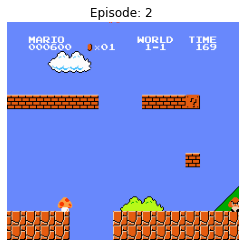

100%|███████████████████████████████████████████████████████████████████████████| 3/3 [02:09<00:00, 43.21s/it]


Episode 3 score = 1139.0, average score = 825.6666666666666


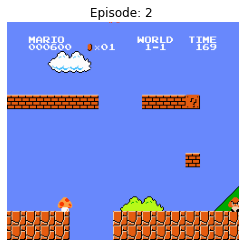

In [ ]:
# For training
run(training_mode=True, pretrained=True, double_dqn=True, num_episodes=3, exploration_max = 1)

# For Testing
run(training_mode=False, pretrained=True, double_dqn=True, num_episodes=3, exploration_max = 0.05)
 

スーパーマリオブラザーズ」は、1980年代に任天堂が開発・発売した有名なゲームタイトルである。
1980年代に任天堂が開発・発売したゲームソフトで、説明不要の名作中の名作である。
2Dの横スクロールゲームで、プレイヤーは主人公のマリオを操作することができます。

ゲーム内容は、マリオを左から右へと移動させながら、悪役を退け、コインを手に入れ、旗にたどり着くとステージクリアとなります。
マリオは最終的にヒキガエル姫を救う必要があります。
このゲームには、コイン、悪役、穴、クリアタイムなどの報酬システムがあります。

ゲーム環境は、Nintendo Entertainment System（NES）のpythonエミュレータを使用したOpenAI Gymから取得しました。
今回は、PyTorchライブラリを使って、Deep Q-Network（DQN）とDeep Double Q-Network（DDQN）を使った強化学習アルゴリズムを実装し、それぞれの性能を検証する方法を紹介します。
そして、それぞれのアルゴリズムで行った実験を評価しました。
<!-- Super Mario Bros is a well-known video game title developed and published by Nintendo in the 1980s. 
It is one of the classical game titles that lived through the years and need no explanations. 
It is a 2D side-scrolling game, allowing the player to control the main character — Mario.

The gameplay involves moving Mario from left to right, surviving the villains, getting coins, and reaching the flag to clear stages. 
Mario would ultimately need to save the princess toadstool. 
These come with different reward systems, coins, villains, holes, and completion time.

The game environment was taken from the OpenAI Gym using the Nintendo Entertainment System (NES) python emulator. 
In this article, I will show how to implement the Reinforcement Learning algorithm using Deep Q-Network (DQN) and Deep Double Q- Network (DDQN) algorithm using PyTorch library to examine each of their performance. 
The experiments conducted on each algorithm were then evaluated.
 -->

# データの理解と前処理
<!-- # Data understanding and preprocessing -->

スーパーマリオブラザーズのオリジナルの観測空間は 240×256×3 の RGB 画像です。
行動空間は 256 で，エージェントは 256 の異なる可能な行動を取ることができることを意味します。
我々のモデルの学習時間を短縮するために，ジムのラッパー関数を使って，元の環境にある種の変換を適用しました。

* エージェントの各行動を 4 つのフレームで繰り返し，ビデオフレームのサイズを小さくする。すなわち，環境の各状態は 4×84×84×1 (連続した 84×84 のグレースケールピクセルフレームのリスト) となる。
* 画素値を 0 から 1 の範囲に正規化する
* アクションの数を 5 (右のみ), 7 (単純な動き), 12 (複雑な動き) に減らす

<!--
The original observation space for Super Mario Bros is 240 x 256 x 3 an RGB image. 
And the action space is 256 which means the agent is able to take 256 different possible actions. 
In order to speed up the training time of our model, we have used the gym’s wrapper function to apply certain transformations to the original environment:

* Repeating each action of the agent over 4 frames and reducing the video frame size, i.e. each state in the environment is a 4 x 84 x 84 x 1 (a list of 4 continuous 84 x 84 grayscale pixel frames)
* Normalizing the pixel value to the range from 0 to 1
* Reducing the number of actions to 5 (Right only), 7 (Simple movement) and 12 (Complex movement) -->

# 理論的な結果
<!-- # Theoretical Results -->

当初， 状態と行動の対の値の可能なすべての組み合わせを格納するために 2 次元配列を使用する Q-学習を使用して実験を行うことを考えていました。
しかし， 今回の環境設定では，非常に大きな Q テーブルを格納する必要があるため Q 学習を適用することは不可能であることがわかりました。

そこで本プロジェクトでは DQN アルゴリズムをベースラインモデルとして採用しました。
DQN アルゴリズムは， 与えられた状態で取るべき最適な行動を学習するために Q-学習 を使用し， Q-値関数を推定するためにディープニューラルネットワークを使用します。

使用した深層ニューラルネットワークは 3 層の畳み込みニューラルネットワークと，それに続く 2 つの完全連結線形層で構成されており， 各可能なアクションに対して 1 つの出力を持ちます。
このネットワークは Q-学習アルゴリズムの Q テーブルのように機能します。
目的の損失関数としては Huber 損失 (Q 値の平滑化された平均絶対誤差) を使用しました。
Huber 損失は MSE と MAE の両方を組み合わせて目的関数を最小化します。
目的関数の最適化に使用したオプティマイザーは Adam です。

<!--
Initially, I am thinking to perform an experiment using Q-learning which uses a 2-D array to store all possible combinations of state and action pair values. 
However, in this environment setting, I realized that it is impossible to apply Q-learning as there is a requirement to store a very large Q-table and this is not feasible.

Therefore, this project used the DQN algorithm as the baseline model. 
DQN algorithms use Q- learning to learn the best action to take in the given state and a deep neural network to estimate the Q- value function.

The type of deep neural network I used is a 3 layers convolutional neural network followed by two fully connected linear layers with a single output for each possible action. 
This network works like the Q-table in the Q-Learning algorithm. 
The objective loss function we used is Huber loss or smoothed mean absolute error on Q-values. 
Huber loss combines both MSE and MAE to minimize the objective function. The optimizer we used to optimize the objective function is Adam. -->

しかし、DQNネットワークには過大評価という問題があります。
<!-- However, the DQN network has the problem of overestimation. -->

<img src="https://editor.analyticsvidhya.com/uploads/26952Capture.PNG" width="66%"><br/>
Figure 1: Illustration of how the DQN network is overestimated

図 1 に示すように、過大評価の原因は主に 2 つあります。
1 つ目の理由は、目標値を計算する際に使用する最大化関数に起因します。
ここでは、真の行動値を次のように表します。$x(a_{1}),\ldots,x(a_{n})$ とします。
DQN によるノイジーな推定値を $Q(s,a_{1};w),\ldots,Q(s, a_{n};w)$ とします。
数学的には:
<!-- There are 2 main reasons for overestimation as shown in Fig1. 
The first reason is due to the maximization function used to calculate the target value. 
Let’s assume the True action-values are denoted by: x(a_1),ldots,x(a_{n}). 
Noisy estimations made by DQN are denoted by Q(s,a_{1};w),ldots,Q(s, a_{n};w) 
Mathematically, -->

$$
\max_{a} Q(s,a,w) \ge \max_{a}(x(a))
$$

<!-- # Experiment Results

There were 5 experiments conducted based on different movements of the agent using 2 algorithms, DQN and DDQN. 
The different movements are complex movements, simple movements, and right-only movements.

The parameters settings are as follows :

* Observation space: 4 x 84 x 84 x 1
* Action space: 12 (Complex Movement) or 7 (Simple Movement) or 5 (Right only movement)
* Loss function: HuberLoss with δ = 1
* Optimizer: Adam with lr = 0.00025
* betas = (0.9, 0.999)
* Batch size = 64 Dropout = 0.2
* gamma = 0.9
* Max memory size for experience replay = 30000
* For epsilon greedy: Exploration decay = 0.99, Exploration min = 0.05

At the beginning of exploration, max = 1, the agent will take random action. 
After each episode, it will decay by the exploration decay rate until it reaches an exploration min of 0.05. -->


<!-- # Experiment 1

The first experiment conducted was to compare DDQN and DQN algorithms for the complex movement of the agent.

<img src="https://editor.analyticsvidhya.com/uploads/52009Capture.PNG"> -->


<!-- 
# Experiment 2
The second experiment conducted was to compare DDQN and DQN algorithms for the simple movement of the agent. 
<img src="https://editor.analyticsvidhya.com/uploads/23645Capture.PNG"> 
-->